## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from hazm import *
import nltk
from perke.unsupervised.graph_based import *
from yake import *
# from Algorithms.SGRank import sgrank
# import spacy
from sklearn.metrics.pairwise import cosine_similarity

## Loading Data

In [2]:
df = pd.read_json('Text.txt', lines=True).drop('id', axis=1)

In [3]:
df.head()

,body,keywords
0,این نوشتار بر آن است تا با بررسی فقه الحدیثی ک...,"[فقه الحدیث, معانی الاخبار, روش فقه الحدیثی, چ..."
1,چکیده: این پژوهش براساس چارچوب نظری ...,"[سید محمد خاتمی, آدریان لفت ویچ, پیتر ایوانز, ..."
2,فهم معانی عمیق و تدبر در آیات قرآن کریم برای ب...,"[جایگاه آرائ تفسیری, محمد یزدی, ترجمه قرآن]"
3,آزادی موهبتی است الهی که خدای متعال به انسان ع...,"[محدودیت بازدارنده, آزادی بیان, بدعت, دین, ارت..."
4,یکی از نکاتی که توجه پژوهشگران اندیشه‌های سیاس...,"[آزادی, محمد تقی مصباح یزدی, مرتضی مطهری, دموک..."


In [4]:
kw_vect = CountVectorizer(ngram_range=(1, 10))
index = 53
a = []
kw = df.keywords[53]

sentence = df.body.iloc[index]
sentence_ngrams = kw_vect.fit([sentence])
sentence_features = kw_vect.get_feature_names_out()
for k in kw:
    if k in sentence_features:
        a.append(k)
    else:
        a.append(k)

## PreProcessing

In [5]:
df['other_keywords'] = [[] for i in range(len(df))]
df['true_keywords'] = [[] for i in range(len(df))]

kw_vect = CountVectorizer(ngram_range=(1, 10))

for index, kw in enumerate(df.keywords):
    sentence = df.body.iloc[index]
    sentence_ngrams = kw_vect.fit([sentence])
    sentence_features = kw_vect.get_feature_names_out()
    for k in kw:
        if k in sentence_features:
            df['true_keywords'].iloc[index].append(k)
        else:
            df['other_keywords'].iloc[index].append(k)

df['keywords'] = df['true_keywords']
df.drop('true_keywords', axis=1, inplace=True)

In [6]:
key_words_OOT = []
key_words_IOT = []

for index, keyword in enumerate(df.keywords):
    txt = df.iloc[index]['body']
    key_words_OOT_tmp = []
    key_words_IOT_tmp = []

    for kw in keyword:
        if kw in txt:
            key_words_IOT_tmp.append(kw)

        else:
            key_words_OOT_tmp.append(kw)

    key_words_OOT_tmp.append(key_words_OOT_tmp)
    key_words_IOT.append(key_words_IOT_tmp)

In [7]:
tokenizer = WordTokenizer(replace_links=True,
                          replace_emails=True, replace_numbers=True, replace_hashtags=True, )

In [8]:
from collections import Counter

df['normalized'] = None
df['tokenized'] = None
df['sticked_tokenized'] = None

normalizer = Normalizer()
inf_normalizer = InformalNormalizer(seperation_flag=True)

for index in range(len(df)):
    text = df.iloc[index]['body']
    text = normalizer.normalize(text)

    df['normalized'][index] = text

    text = tokenizer.tokenize(text)
    df['tokenized'][index] = text
    df['sticked_tokenized'][index] = " ".join(text)

In [9]:
tfidf = TfidfVectorizer(stop_words=utils.stopwords_list(), ngram_range=(1, 5))
tfidf_scores = tfidf.fit_transform(df.sticked_tokenized).toarray()
features = tfidf.get_feature_names_out()

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند'] not in stop_words.
  warnings.warn(


In [10]:
tfidf_scores.shape

(450, 284302)

In [11]:
features.shape

(284302,)

### Metrics

In [14]:
def f1_score(precision, recall):
    return 2*precision*recall/(precision + recall + 0.0001)

In [39]:
def text_metrics(preds, trues):
    length = len(preds)
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(length):
        pred = preds[i]
        true = trues[i]

        prec = precision(pred, true)
        rec = recall(pred, true)
        f1 = f1_score(prec, rec)

        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    precisions = sum(precisions)/length
    recalls = sum(recalls)/length
    # f1_scores = sum(f1_scores)/length
    # f1_scores = f1_score(precisions, recalls)

    return precisions, recalls, f1_scores

In [15]:
def text_metrics(preds, trues):
    tp = 0
    fp = 0
    fn = 0
    
    for index, pred in enumerate(preds):
        true = trues[index]

        for phrase in pred:
            if phrase in true:
                tp += 1
            else:
                fp += 1
                
        for phrase in true:
            if phrase not in pred:
                fn += 1

    prec = tp / (tp+fp+0.000001)
    rec = tp / (tp+fn+0.000001)
    f1 = f1_score(prec, rec)

    return prec, rec, f1

### Filters

#### Filter 1: remove KeyPhrases Longer than 3 Words

In [16]:
def filter1(preds):
    final_preds = []
    for index, pred in enumerate(preds):
        # print(pred)
        final_preds.append(pred.copy())
        for kp in pred:
            length = len(kp.split())
            if length > 3:
                final_preds[index].remove(kp)

    return final_preds

#### Filter 2: Mixing One Words

In [17]:
def return_one_words(pred):
    ones = []
    for kp in pred:
        if len(kp.split()) == 1:
            ones.append(kp)
    return ones

def mix_ones(ones):
    output = {}
    # print(ones)
    if len(ones) > 1:
        for index, word1 in enumerate(ones):
            # for word2 in ones[index:]:
            for word2 in ones:
                if word1 != word2:
                    output[word1 + " " + word2] = [word1, word2]

    else:
        output = {None:None}
    return output

In [18]:
def filter2(preds, text_ngrams, word2score):
    output_preds = []
    for index, pred in enumerate(preds):
        output_preds.append(pred.copy())
        ones = return_one_words(pred)
        mixed = mix_ones(ones)
        
        for key in mixed.keys():

            if key in text_ngrams[index]:
                word1 = mixed[key][0]
                word2 = mixed[key][1]
                try:
                    word1_score = word2score[word1]
                    word2_score = word2score[word2]
                    candidate_score = word2score[key]
                    
                    mean_score = 0.45 * (word1_score + word2_score)
                    if candidate_score >= mean_score:
                        # print(key)
                        try:
                            output_preds[index].remove(word1)
                            output_preds[index].remove(word2)
                            pass
                        except:
                            pass

                        if key not in output_preds[index]:
                            output_preds[index].append(key)

                except:
                    pass

    return output_preds

#### Filter 3: KeyPhrase Subsets Remove

In [19]:
def filter3(preds, word2score):
    output_preds = []
    for index, pred in enumerate(preds):
        output_preds.append(pred.copy())
        for small_kp in pred:
            small_words = small_kp.split()
            # print('small_kp', small_kp)
            for big_kp in pred:
                big_words = big_kp.split()
                # print(small_words, big_words)
            
                if len(small_words) < len(big_words):
                    vectorizer = CountVectorizer(ngram_range=(1, len(big_words)))
                    vectorizer.fit([big_kp])
                    big_ngrams = vectorizer.get_feature_names_out()
                    if small_kp in big_ngrams:
                        
                        try:
                            small_score = word2score[small_kp]
                            big_score = word2score[big_kp]
                        
                            if word2score[small_kp]*0.6 <= word2score[big_kp]:
                                try:
                                    output_preds[index].remove(small_kp)
                                except:
                                    continue

                            elif word2score[small_kp] > 4.2*word2score[big_kp]:
                                try:
                                    output_preds[index].remove(big_kp)
                                except:
                                    continue
                        
                        
                        except:   
                            pass

    return output_preds

## TF-IDF BaseLine

In [909]:
def choose_keywords(sentences_scoreVec, features, threshold):
    df_keywords = []
    for vector in sentences_scoreVec:
        sentence_keywords = []
        idx_score = list(enumerate(vector))
        for tople in idx_score:
            idx = tople[0]
            score = tople[1]
            if score > threshold:
                sentence_keywords.append((idx, features[idx]))

        df_keywords.append(sentence_keywords)

    return df_keywords

In [907]:
# word2score = {}
# scores = tfidf_scores.max(axis=0)

# for feature, index in tfidf.vocabulary_.items():
#     score = scores[index]
#     word2score[feature] = score

# descrete_ngrams = []
# for text in df.sticked_tokenized:
#     tfidf.fit([text])
#     ngrams = tfidf.get_feature_names_out()
#     descrete_ngrams.append(ngrams)

In [913]:
# threshold = 0.09
# precisions = []
# recalls = []
# f1_scores = []
# keywords = df.keywords

# for i in range(1):
#     pred_keywords = choose_keywords(tfidf_scores, features, threshold)
#     pred_keywords = filter1(pred_keywords)
#     pred_keywords = filter2(pred_keywords, descrete_ngrams, word2score)
#     pred_keywords = filter3(pred_keywords, word2score)



#     epoch_precision = []
#     epoch_recall = []
#     epoch_f1_score = []

#     for idx, sentence_KW in enumerate(pred_keywords):
#         kw_words = [s[1] for s in sentence_KW]

#         true_positive = 0
#         false_positive = 0
#         false_negative = 0

#         true_kw = keywords[idx]
#         total_count = len(true_kw)

#         for kw in kw_words:
#             if kw in true_kw:
#                 true_positive += 1
#             else:
#                 false_positive += 1

#         for t_kw in true_kw:
#             if t_kw not in kw_words:
#                 false_negative += 1

#         precision = true_positive / (true_positive + false_positive + 0.0001)
#         recall = true_positive / (true_positive + false_negative + 0.0001)
#         f1_score = 2*precision*recall/(precision + recall + 0.0001)

#         epoch_precision.append(precision)
#         epoch_recall.append(recall)
#         epoch_f1_score.append(f1_score)

#     precisions.append(np.mean(epoch_precision))
#     recalls.append(np.mean(epoch_recall))
#     f1_scores.append(np.mean(epoch_f1_score))
#     # threshold += 0.01

# # best threshold = 0.09

In [ ]:
# thresholds = np.linspace(5, 20, 15)/100
# recalls = np.array(recalls)
# precisions = np.array(precisions)
# f1_scores = np.array(f1_scores)

# plt.plot(thresholds, recalls*100, 'r', label='Recall')
# plt.plot(thresholds, precisions*100, 'b', label='Precision')
# plt.plot(thresholds, f1_scores*100, 'd--', label='F1_Score')

# plt.grid(visible=True)
# plt.ylabel('Percent')
# plt.xlabel('Threshold')

# leg = plt.legend()

## Singlerank

In [ ]:
def Singlerank(texts, n):
    kp = []
    
    for text in texts:
        extractor = SingleRank()
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()
        extractor.weight_candidates(normalize_weights=True, remove_redundants=True, window_size=10)

        keyphrases = extractor.get_n_best(n=n)

        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [ ]:
# precisions = []
# recalls = []
# f1_scores = []
# trues = df.keywords

# for n in range(5, 20):
#     key_phrases = Singlerank(df.normalized[:20], n)

#     prec, rec, f1 = text_metrics(key_phrases, trues)
    
#     precisions.append(prec)
#     recalls.append(rec)
#     f1_scores.append(f1)

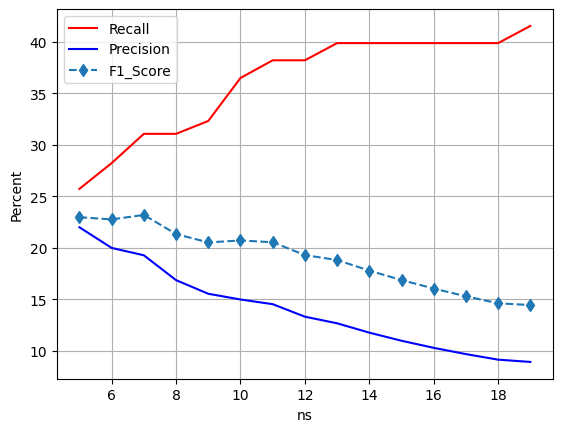

In [ ]:
ns = np.linspace(5, 19, 15)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('ns')

leg = plt.legend()

## Textrank

In [ ]:
def Textrank(texts, n):
    kp = []
    
    for text in texts:
        extractor = TextRank()
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()
        extractor.weight_candidates(normalize_weights=True, window_size=10)

        keyphrases = extractor.get_n_best(n=n)
        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(5, 20):
    key_phrases = Textrank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

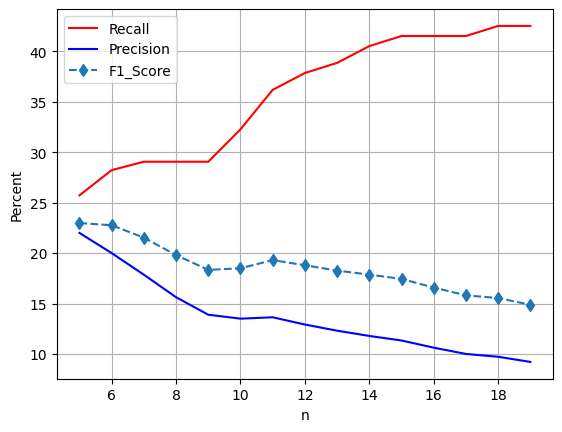

In [ ]:
ns = np.linspace(5, 19, 15)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## Position Rank

In [ ]:
def Positionrank(texts, n):
    valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
    # valid_pos_tags = {'NOUN', 'ADJ'}
    grammar = r"""
        NP:
            {<NOUN>}<VERB>
        NP:
            {<DET(,EZ)?|NOUN(,EZ)?|NUM(,EZ)?|ADJ(,EZ)|PRON><DET(,EZ)|NOUN(,EZ)|NUM(,EZ)|ADJ(,EZ)|PRON>*}
            <NOUN>}{<.*(,EZ)?>
    """

    # grammar = r"""
    #         NP:
    #                 {<NOUN,EZ>?<NOUN.*>}    # Noun(s) + Noun(optional)
             
    #         NP:
    #                 {<NOUN.*><ADJ.*>}    # Noun(s) + Adjective(optional)
    #         """
    kp = []
    for text in texts:
        extractor = PositionRank(valid_pos_tags=valid_pos_tags)
        extractor.load_text(input=text, word_normalization_method=None)
        extractor.select_candidates(grammar=grammar, maximum_word_number=4)
        # extractor.select_candidates(maximum_word_number=4)
        extractor.weight_candidates(normalize_weights=True)

        keyphrases = extractor.get_n_best(n=n)
        # print(keyphrases)
        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(4, 8):
    key_phrases = Positionrank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

KeyboardInterrupt: 

: 

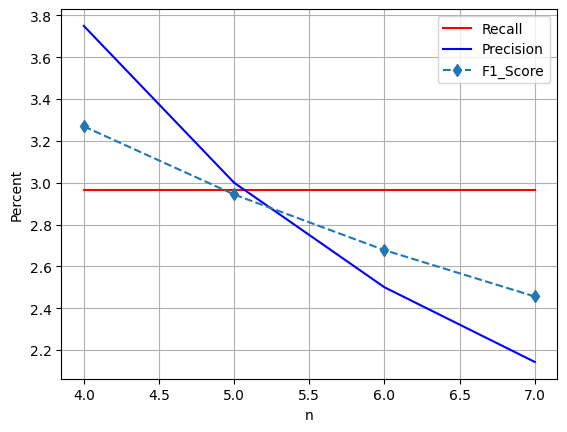

In [ ]:
ns = np.linspace(4, 7, 4)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## Topic Rank

In [ ]:
def Topicrank(texts, n):
    kp = []
    
    for text in texts:
        extractor = TopicRank()
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()
        extractor.weight_candidates()

        keyphrases = extractor.get_n_best(n=n)

        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp



    # extractor.weight_candidates(
    #     threshold=0.74, metric='jaccard', linkage_method='average'
    # )


In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

n = 3

for i in range(4):
    key_phrases = Topicrank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    n += 1

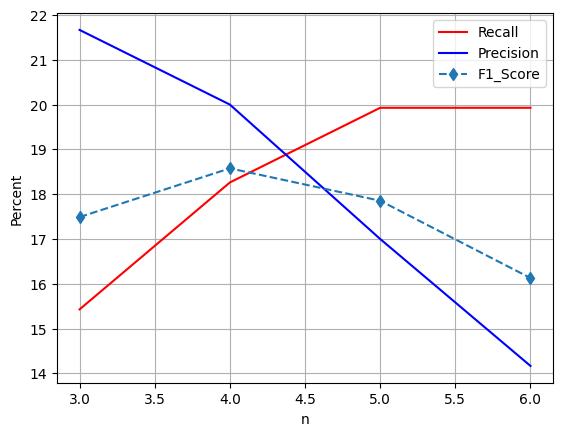

In [ ]:
ns = np.linspace(3, 6, 4)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## Multi Partite Rank

In [ ]:
def multiPartiteRank(texts, n):
    valid_pos_tags = {'NOUN', 'ADJ'}
    
    kp = []
    
    for text in texts:
        extractor = MultipartiteRank(valid_pos_tags=valid_pos_tags)
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()

        # extractor.weight_candidates()
        extractor.weight_candidates(
        threshold=0.74,
        metric='jaccard',
        linkage_method='average',
        alpha=1.1,
        )

        keyphrases = extractor.get_n_best(n=n)

        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp


In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(4, 10):
    key_phrases = multiPartiteRank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)


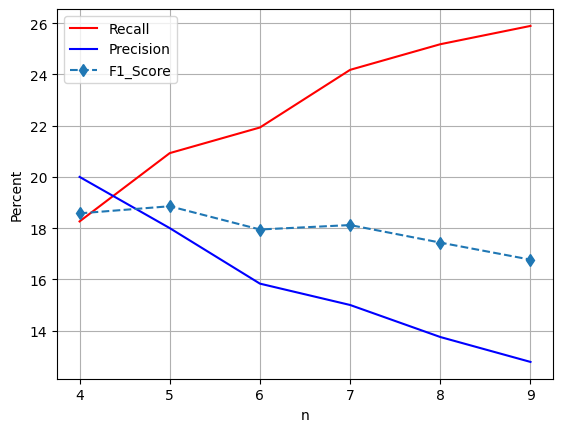

In [ ]:
ns = np.linspace(4, 9, 6)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## YAKE!

In [ ]:
# best params: n=7, dedupLim=no matter, 
def yake(texts, n=7):
	all_keywords = []	

	for text in texts:
		kw_extractor = KeywordExtractor(n=3, dedupLim=0.4, features=None, lan="fa")
		keywords = kw_extractor.extract_keywords(text)
		keywords = [kw[0] for kw in keywords[:n]]
		all_keywords.append(keywords)

	return all_keywords

In [ ]:
trues = df.keywords

precisions = []
recalls = []
f1_scores = []

kw = yake(df.normalized)
prec, rec, f1 = text_metrics(kw, trues)

precisions.append(prec)
recalls.append(rec)
f1_scores.append(f1)
    

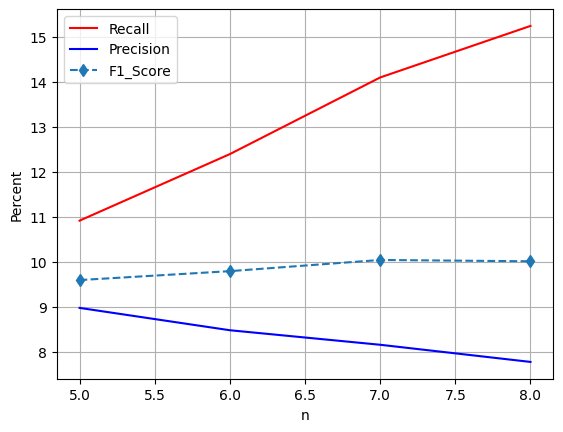

In [ ]:
ns = np.linspace(5, 8, 4)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## SG Rank

In [ ]:
# import Algorithms
txt = df.normalized.iloc[0]
SGRank.sgrank([txt], 5)

AttributeError: 'str' object has no attribute 'start'

## Embed Rank

In [25]:
def extract_candidates(tagged, grammer):
    ## you can also add your own grammer to be extracted from the text...

    
    keyphrase_candidate = set()
    np_parser = nltk.RegexpParser(grammer)
    trees = np_parser.parse_sents(tagged)
    for tree in trees:
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):  # For each nounphrase
            # Concatenate the token with a space
            keyphrase_candidate.add(' '.join(word for word, tag in subtree.leaves()))
    keyphrase_candidate = {kp for kp in keyphrase_candidate if len(kp.split()) <= 5}
    keyphrase_candidate = list(keyphrase_candidate)
    return keyphrase_candidate


In [ ]:
model_path = 'pos_tagger.model'
tagger = POSTagger(model = model_path)
token_tag_list = []
for text_tokens in df.tokenized:
    posed = tagger.tag_sents([text_tokens])
    token_tag_list.append(posed)

In [ ]:
grammers = [
            """
            NP:
                    {<NOUN,EZ>?<NOUN.*>}    # Noun(s) + Noun(optional)
            """ ,

            """
            NP:
                    {<NOUN.*><ADJ.*>}    # Noun(s) + Adjective(optional)
            """]

all_candidates1 = []

for token_tag in token_tag_list:
        temp_candidate = extract_candidates(token_tag, grammers[0])
        temp_candidate += extract_candidates(token_tag, grammers[1])
        all_candidates1.append(np.array(temp_candidate))


In [ ]:
# all_candidates = Textrank(df.normalized, 100)

In [ ]:
# all_candidates1 = all_candidates

In [ ]:
sent2vec_model_path = 'sent2vec\sent2vec-naab.model'
sent2vec_model = SentEmbedding(sent2vec_model_path)

In [ ]:
all_candidates_vectors = []
for keyPhrases in all_candidates1:
    candidadte_vec = np.asarray([sent2vec_model[candidate] for candidate in keyPhrases])
    all_candidates_vectors.append(candidadte_vec)

# all_candidates_vectors = np.ndarray(all_candidates_vectors)

In [ ]:
all_sentences_vectors = []
for txt in df.normalized:
    sentence_vectorized = sent2vec_model[txt]
    all_sentences_vectors.append(sentence_vectorized)
    
# all_sentences_vectors = np.asarray(all_sentences_vectors)

In [ ]:
all_candidate_sim_candidate = []
for candidate in all_candidates_vectors:
    candidate_sim_candidate = cosine_similarity(candidate)
    all_candidate_sim_candidate.append(candidate_sim_candidate)

In [ ]:
all_candidates_sim_whole = []
for i in range(450):
    text_embeding = all_sentences_vectors[i]
    candidate_embeddings = all_candidates_vectors[i]
    
    similarity = cosine_similarity(candidate_embeddings, text_embeding.reshape(1,-1))
    similarity = similarity.reshape(1,-1)
    all_candidates_sim_whole.append(similarity)

# all_candidates_sim_whole[n] = cosine_similarity of all candidates of row 1 with whole text

In [ ]:
for index, candidates_sim_whole in enumerate(all_candidates_sim_whole):
    
    candidates_sim_whole_norm = candidates_sim_whole / np.max(candidates_sim_whole)
    candidates_sim_whole_norm = 0.5 + (candidates_sim_whole_norm - np.average(candidates_sim_whole_norm)) / np.std(candidates_sim_whole_norm)
    all_candidates_sim_whole[index] = candidates_sim_whole_norm[0]

In [ ]:
for index, candidate_sim_candidate in enumerate(all_candidate_sim_candidate):
    
    np.fill_diagonal(candidate_sim_candidate, np.NaN)
    candidate_sim_candidate_norm = candidate_sim_candidate / np.nanmax(candidate_sim_candidate, axis=0)
    candidate_sim_candidate_norm = 0.5 + (candidate_sim_candidate_norm - np.nanmean(candidate_sim_candidate_norm, axis=0)) / np.nanstd(candidate_sim_candidate_norm, axis=0)
    all_candidate_sim_candidate[index] = candidate_sim_candidate_norm

In [ ]:
from operator import itemgetter 
beta = 0.82
keyword_count = 7
kp_preds = []

for index in range(450):
    candidates = all_candidates1[index]
    N = min(len(candidates), keyword_count)

    selected_candidates = []
    unselected_candidates = [i for i in range(len(candidates))]
    best_candidate = np.argmax(all_candidates_sim_whole[index])
    selected_candidates.append(best_candidate)
    unselected_candidates.remove(best_candidate)


    for i in range(N-1):
        selected_vec = np.array(selected_candidates)
        unselected_vec = np.array(unselected_candidates)
    
        unselected_candidate_sim_whole = all_candidates_sim_whole[index][unselected_vec]

        dist_between = all_candidate_sim_candidate[index][unselected_vec]

        if dist_between.ndim == 1:
            print('if runed')
            dist_between = dist_between[:, np.newaxis]

        best_candidate = np.argmax(beta * unselected_candidate_sim_whole - (1 - beta) * np.nanmax(dist_between, axis = 1))
        best_index = unselected_candidates[best_candidate]
        

        selected_candidates.append(best_index)
        unselected_candidates.remove(best_index)

    kp_pred = itemgetter(*selected_candidates)(all_candidates1[index])
    kp_preds.append(list(kp_pred))

In [ ]:
prec, rec, f1 = text_metrics(kp_preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") #0.074,  0.4, 0.62

kp_preds1 = filter1(kp_preds)
prec, rec, f1 = text_metrics(kp_preds1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") #0.074,  0.4, 0.62

kp_preds1 = filter2(kp_preds, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(kp_preds1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") #0.074,  0.4, 0.62

kp_preds1 = filter3(kp_preds, word2score)
prec, rec, f1 = text_metrics(kp_preds1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") #0.074,  0.4, 0.62

Precision: 0.06476097960505321, Recall: 0.10564814785904218, F1-Score: 0.08025233194923001
Precision: 0.06476097960505321, Recall: 0.10564814785904218, F1-Score: 0.08025233194923001
Precision: 0.06460224906844358, Recall: 0.10509260619202831, F1-Score: 0.07996966351017344
Precision: 0.06684549684821532, Recall: 0.10085198737605373, F1-Score: 0.0803528281183516


## TF-idf with chunking, KP-Miner

In [20]:
def increment_score(kp, score):
    length = len(kp.split())

    factor1 = 0.045
    factor2 = 0.12
    factor3 = 0.03
    # 100:
    # 045, 12, 03 ==> Precision: 0.3845, Recall: 0.3242, F1-Score: 0.3518
    
    # whole:
    # 04, 10, 03  ==> Precision: 0.3656, Recall: 0.3094, F1-Score: 0.3351


    if length == 1:
        score += factor1

    if length == 2:
        score += factor2

    if length == 3:
        score += factor3

    return score

### N_Grams

In [21]:
tfidf = TfidfVectorizer(stop_words=utils.stopwords_list(), ngram_range=(1, 3))
tfidf_scores = tfidf.fit_transform(df.sticked_tokenized).toarray()
features = tfidf.get_feature_names_out()

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند'] not in stop_words.
  warnings.warn(


In [22]:
word2score = {}
scores = tfidf_scores.max(axis=0)

for feature, index in tfidf.vocabulary_.items():
    score = scores[index]
    word2score[feature] = score

In [23]:
descrete_ngrams = []
for text in df.sticked_tokenized:
    tfidf.fit([text])
    ngrams = tfidf.get_feature_names_out()
    descrete_ngrams.append(ngrams)

### Model

In [26]:
model_path = 'pos_tagger.model'
tagger = POSTagger(model = model_path)
token_tag_list = []
for text_tokens in df.tokenized:
    posed = tagger.tag_sents([text_tokens])
    token_tag_list.append(posed)

grammers = [
            """
            NP:
                    {<NOUN,EZ>?<NOUN.*>}    # Noun(s) + Noun(optional)
            """ ,

            """
            NP:
                    {<NOUN.*><ADJ.*>}    # Noun(s) + Adjective(optional)
            """]

all_candidates1 = []

for token_tag in token_tag_list:
        temp_candidate = extract_candidates(token_tag, grammers[0])
        temp_candidate += extract_candidates(token_tag, grammers[1])
        all_candidates1.append(np.array(temp_candidate))

In [27]:
trues = df.keywords
chunk_indexes = []  # 2m, 44s
chunk_features = []
chunk_scores = []

for i in range(450):
    tmp_indexes = []
    tmp_features = []
    tmp_scores = []

    for index, feature in enumerate(features):
        if feature in all_candidates1[i]:
            tmp_indexes.append(index)
            tmp_features.append(feature)
            score = tfidf_scores[i][index]
            score = increment_score(feature, score)
            tmp_scores.append(score)

    chunk_indexes.append(tmp_indexes)
    chunk_features.append(tmp_features)
    chunk_scores.append(tmp_scores)


feature_score = []

for i in range(len(chunk_features)):
    tmp = []
    for feature, score in zip(chunk_features[i], chunk_scores[i]):
        tmp.append((feature, score))

    feature_score.append(sorted(tmp, key=lambda x : x[1], reverse=True))

### With Threshold

In [36]:
preds = []
for pred in feature_score:
    tmp_pred = []
    for feature, score in pred:
        if score >= 0.2012:
            tmp_pred.append(feature)

    preds.append(tmp_pred)

prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")     

preds = filter2(preds, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

preds = filter3(preds, word2score)
prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

Precision: 0.3014306855937688, Recall: 0.32293868904707257, F1-Score: 0.31176430549600104
Precision: 0.3072289155084192, Recall: 0.32346723027300883, F1-Score: 0.3150890728293176
Precision: 0.3401281302620104, Recall: 0.30866807594679274, F1-Score: 0.32358548112568875


In [40]:
prec, rec, f1 = text_metrics(preds, trues)

In [48]:
df.iloc[map(lambda x : True if x == 0.0 else False, f1)]

,body,keywords,other_keywords,normalized,tokenized,sticked_tokenized
1,چکیده: این پژوهش براساس چارچوب نظری ...,"[سید محمد خاتمی, آدریان لفت ویچ, پیتر ایوانز, ...",[دولت توسعه گرا],چکیده: این پژوهش براساس چارچوب نظری دولت توسعه...,"[چکیده, :, این, پژوهش, براساس, چارچوب, نظری, د...",چکیده : این پژوهش براساس چارچوب نظری دولت توسع...
3,آزادی موهبتی است الهی که خدای متعال به انسان ع...,"[آزادی بیان, بدعت, دین, ارتداد, کتب ضلال, اهان...","[محدودیت بازدارنده, قانون مدنی]",آزادی موهبتی است الهی که خدای متعال به انسان ع...,"[آزادی, موهبتی, است, الهی, که, خدای, متعال, به...",آزادی موهبتی است الهی که خدای متعال به انسان ع...
11,هدف از پژوهش حاضر تعیین تاثیر آموزش فلسفه برای...,"[اجتماع پژوهشی, آموزش فلسفه برای کودکان]","[تاب‌آوری, انعطاف‌پذیری شناختی]",هدف از پژوهش حاضر تعیین تاثیر آموزش فلسفه برای...,"[هدف, از, پژوهش, حاضر, تعیین, تاثیر, آموزش, فل...",هدف از پژوهش حاضر تعیین تاثیر آموزش فلسفه برای...
14,اصل امامت و ولایت و نیز فضائل اهل بیت پیامبراک...,"[محمد عزه دروزه, سیاق, روایات سبب نزول]","[آیات امامت و ولایت, التفسیرالحدیث]",اصل امامت و ولایت و نیز فضائل اهل‌بیت پیامبراک...,"[اصل, امامت, و, ولایت, و, نیز, فضائل, اهل‌بیت,...",اصل امامت و ولایت و نیز فضائل اهل‌بیت پیامبراک...
15,این رساله، به بررسی تحلیلی و تطبیقی دیدگاه‌ها ...,"[علامه طباطبایی, علامه جوادی آملی, آیات توحیدی...",[برهان],این رساله، به بررسی تحلیلی و تطبیقی دیدگاه‌ها ...,"[این, رساله, ،, به, بررسی, تحلیلی, و, تطبیقی, ...",این رساله ، به بررسی تحلیلی و تطبیقی دیدگاه‌ها...
...,...,...,...,...,...,...
439,بخش عمده‌ای از آثار منثور فارسی به نثرهای عرفا...,"[رساله قشیریه, مرصادالعباد, کشف المحجوب, کیمیا...",[کتاب‌های تعلیمی عرفانی],بخش عمده‌ای از آثار منثور فارسی به نثرهای عرفا...,"[بخش, عمده‌ای, از, آثار, منثور, فارسی, به, نثر...",بخش عمده‌ای از آثار منثور فارسی به نثرهای عرفا...
444,ملاصدرا مانند سایر فلاسفه اسلامی با دو تلقی از...,"[ملاصدرا, عقل نظری, نهج البلاغه, عقل عملی]",[کمال انسانی ‌],ملاصدرا مانند سایر فلاسفه اسلامی با دو تلقی از...,"[ملاصدرا, مانند, سایر, فلاسفه, اسلامی, با, دو,...",ملاصدرا مانند سایر فلاسفه اسلامی با دو تلقی از...
446,سازمان ملل متحد در دهه های اخیر، با تغییر ساخت...,"[کمیسیون حقوق بشر, حقوق بشر در ایران, شورای حق...","[بررسی دوره‌ای جهانی, ضمانت اجرای تصمیمات شورا...",سازمان ملل متحد در دهه‌های اخیر، با تغییر ساخت...,"[سازمان, ملل, متحد, در, دهه‌های, اخیر, ،, با, ...",سازمان ملل متحد در دهه‌های اخیر ، با تغییر ساخ...
448,هدف از انجام این تحقیق بررسی تاثیر کیفیت زندگی...,"[نوع دوستی, رفتار شهروندی سازمانی, تواضع, کیفی...",[مدل GSTARS 2.1],هدف از انجام این تحقیق بررسی تاثیر کیفیت زندگی...,"[هدف, از, انجام, این, تحقیق, بررسی, تاثیر, کیف...",هدف از انجام این تحقیق بررسی تاثیر کیفیت زندگی...


In [55]:
preds[449]

['زندگی کاری', 'عملکرد شغلی', 'کیفیت زندگی', 'واحد مرودشت', 'کارکنان دانشگاه']

In [56]:
trues[449]

['کارکنان', 'کیفیت زندگی کاری']

### With N_Best

In [35]:
preds = []
n_best = 4
for pred in feature_score:
    tmp_pred = []
    for feature, score in pred[:n_best]:
        tmp_pred.append(feature)

    preds.append(tmp_pred)

prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")     

preds = filter2(preds, descrete_ngrams, word2score)

prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

preds = filter3(preds, word2score)

prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

Precision: 0.30999999982777776, Recall: 0.29477020586647107, F1-Score: 0.3021433785549371
Precision: 0.3151071024153849, Recall: 0.2952984678841529, F1-Score: 0.3048314350908338
Precision: 0.3474025971770113, Recall: 0.28262017945978857, F1-Score: 0.31163128202729873


### Test

In [897]:
print('True KeyPhrases From Sentences(80, 85)')
for i in trues[80:85]:
    print(i)

print('-------------------------------------------------------------------------------------------------------------------')
print('Predicted KeyPhrases')
for i in preds[80:85]:
    print(i)

True KeyPhrases From Sentences(80, 85)
['خبر تلویزیونی', 'جنگ نرم', 'امنیت نرم', 'قدرت نرم']
['استقلال', 'امنیت ملی', 'کردستان عراق', 'جمهوری اسلامی ایران']
['عوامل انحراف', 'نهج البلاغه', 'موانع انحراف', 'انحراف اعتقادی']
['حواله', 'انحلال', 'عقد تبعی', 'عقد حواله', 'عقد ضمان']
['امام خمینی', 'دکتر شریعتی', 'بررسی تطبیقی', 'اندیشه سیاسی']
-------------------------------------------------------------------------------------------------------------------
Predicted KeyPhrases
['امنیت نرم', 'خبر تلویزیونی', 'تقویت امنیت', 'زوج نقاط']
['اقلیم کردستان', 'کردستان عراق', 'امنیت ملی']
['انحراف اعتقادی', 'موانع انحراف']
['عقد', 'عقد ضمان', 'منشاء دین', 'حواله', 'بطلان قرارداد', 'صورت بطلان', 'عقد حواله', 'قرارداد منشاء', 'فسخ']
['اندیشه سیاسی', 'انقلاب اسلامی', 'دکتر شریعتی']


## Runtime Comparison

In [ ]:
trues = df.keywords
# trues = df.keywords + df.other_keywords

### Singlerank

In [918]:
key_phrases_sr = Singlerank(df.normalized, 7)

In [ ]:
prec, rec, f1 = text_metrics(key_phrases_sr, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

key_phrases_sr1 = filter1(key_phrases_sr)
prec, rec, f1 = text_metrics(key_phrases_sr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

key_phrases_sr1 = filter2(key_phrases_sr1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_sr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

key_phrases_sr1 = filter3(key_phrases_sr1, word2score)
prec, rec, f1 = text_metrics(key_phrases_sr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}") 

Precision: 0.15269623132367974, Recall: 0.26670741382030405, F1-Score: 0.19415906120418883
Precision: 0.19250923232663342, Recall: 0.2628715614283458, F1-Score: 0.22220564811914686
Precision: 0.19324994802392353, Recall: 0.26268638704515396, F1-Score: 0.22263195600578115
Precision: 0.24081750225147092, Recall: 0.24619384378403708, F1-Score: 0.24342601342502435


### TextRank

In [919]:
key_phrases_ter = Textrank(df.normalized, 5) 

In [ ]:
prec, rec, f1 = text_metrics(key_phrases_ter, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")
# print(key_phrases_ter)


key_phrases_ter1 = filter1(key_phrases_ter)
prec, rec, f1 = text_metrics(key_phrases_ter1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")
# print(key_phrases_ter)


key_phrases_ter1 = filter2(key_phrases_ter1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_ter1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")
# print(key_phrases_ter)

key_phrases_ter1 = filter3(key_phrases_ter1, word2score)
prec, rec, f1 = text_metrics(key_phrases_ter1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")
# print(key_phrases_ter)

Precision: 0.18444075562933132, Recall: 0.23105231622581876, F1-Score: 0.20508264781396707
Precision: 0.21569791452510764, Recall: 0.22920051684158524, F1-Score: 0.22219437196203598
Precision: 0.21747561600938045, Recall: 0.22975605850859912, F1-Score: 0.22339728305573658
Precision: 0.26502677634874516, Recall: 0.21896709315156718, F1-Score: 0.23975574358880744


### PositionRank

In [920]:
key_phrases_pr = Positionrank(df.normalized, 5) 

In [ ]:
prec, rec, f1 = text_metrics(key_phrases_pr, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_pr1 = filter1(key_phrases_pr)
prec, rec, f1 = text_metrics(key_phrases_pr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_pr1 = filter2(key_phrases_pr1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_pr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_pr1 = filter3(key_phrases_pr1, word2score)
prec, rec, f1 = text_metrics(key_phrases_pr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

Precision: 0.05910992891253294, Recall: 0.0681075277683461, F1-Score: 0.06324083483517959
Precision: 0.05910992891253294, Recall: 0.0681075277683461, F1-Score: 0.06324083483517959
Precision: 0.08614619251447775, Recall: 0.09214914836855506, F1-Score: 0.08899669953384674
Precision: 0.08636840473703883, Recall: 0.09214914836855506, F1-Score: 0.08911526111617699


### TopicRank

In [921]:
key_phrases_tor = Topicrank(df.normalized, 4) 

In [ ]:
prec, rec, f1 = text_metrics(key_phrases_tor, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_tor1 = filter1(key_phrases_tor)
prec, rec, f1 = text_metrics(key_phrases_tor1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_tor1 = filter2(key_phrases_tor1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_tor1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_tor1 = filter3(key_phrases_tor1, word2score)
prec, rec, f1 = text_metrics(key_phrases_tor1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

Precision: 0.16499587510312197, Recall: 0.16331628309278567, F1-Score: 0.16410179937010114
Precision: 0.1768469985934501, Recall: 0.1630385087871867, F1-Score: 0.16961235292824087
Precision: 0.17647661279218976, Recall: 0.1619274285393472, F1-Score: 0.16883936743777372
Precision: 0.17647659427475146, Recall: 0.16160997275696948, F1-Score: 0.16866653127775008


### MultiPartiteRank

In [922]:
key_phrases_mr = multiPartiteRank(df.normalized, 5)

KeyboardInterrupt: 

In [ ]:
prec, rec, f1 = text_metrics(key_phrases_mr, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_mr1 = filter1(key_phrases_mr)
prec, rec, f1 = text_metrics(key_phrases_mr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_mr1 = filter2(key_phrases_mr1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_mr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_mr1 = filter3(key_phrases_mr1, word2score)
prec, rec, f1 = text_metrics(key_phrases_mr1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

Precision: 0.15466357339519873, Recall: 0.19020715680822795, F1-Score: 0.17055428754754812
Precision: 0.16825550496226388, Recall: 0.18948494694689566, F1-Score: 0.17819050507677744
Precision: 0.16869992940738607, Recall: 0.18929977256370376, F1-Score: 0.1783573574205836
Precision: 0.17292193571178135, Recall: 0.18898231678132604, F1-Score: 0.18054587927110705


### yake

In [ ]:
key_phrases_ya = yake(df.normalized)

In [ ]:
prec, rec, f1 = text_metrics(key_phrases_ya, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

# key_phrases_ya1 = filter1(key_phrases_ya)
# prec, rec, f1 = text_metrics(key_phrases_ya1, trues)
# print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_ya1 = filter2(key_phrases_ya1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_ya1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

key_phrases_ya1 = filter3(key_phrases_ya1, word2score)
prec, rec, f1 = text_metrics(key_phrases_ya1, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")

Precision: 0.08190359185344974, Recall: 0.1416989416763587, F1-Score: 0.10375968570404953
Precision: 0.08827371260105382, Recall: 0.13948737012896975, F1-Score: 0.10807521736241706
Precision: 0.08827371260105382, Recall: 0.13948737012896975, F1-Score: 0.10807521736241706


## Exploring Data

In [ ]:
kw_counter = Counter()

for kws in df.keywords:
    for kw in kws:
        kw_count = len(kw.split())
        kw_counter[kw_count] += 1

In [ ]:
for i in kw_counter.items():
    print(i)
    # total 1906 keyphrases
    # 3% keyphrases contain 4 and more words
    # 1839 keyphrases contain 1, 2, 3 words

(2, 1164)
(3, 271)
(1, 404)
(5, 13)
(4, 49)
(7, 2)
(9, 2)
(6, 1)
